In [57]:
import os
import torch
from torchvision.datasets.utils import download_url
from torchtext import data
from torchtext import datasets
import pandas as pd
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [58]:
import models

In [59]:
SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = False

### Load data

In [60]:
# Read data - short version 3400+ documents
reuters = pd.read_pickle('input/reuters_small.pkl')

In [ ]:
# OR 8xsmall size
reuters = pd.read_pickle('input/reuters_small8.pkl')

In [36]:
# OR load full data, if produced. 435 MB. NOT in Github currently. 
# You can produce this in about 30 min with preprocess_data.ipynb
reuters = pd.read_pickle('input/reuters_all.pkl')

In [61]:
print(len(reuters))
reuters[0:2]

3426


,codes,headline,text,classes,classes_pad
0,"[C18, C181, CCAT]",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia...","[25, 26, 44]","[25, 26, 44, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,"[G15, GCAT]",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...,"[80, 90]","[80, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]"


In [62]:
# read classcodes
classcodes= pd.read_csv('input/classcodes.csv')
print(len(classcodes))
#classcodes[0:12]

# add index field to DataFrame
classcodes = classcodes.reset_index()
# Create dictionary index/int to classcode and classcode to int
itocode = dict(zip(classcodes.index, classcodes.Code))
codetoi = dict(zip(classcodes.Code, classcodes.index))
def listToInt(mylist):
    return [codetoi[item] for item in mylist]

reuters['codes'] = [listToInt(codelist) for codelist in reuters.codes]
reuters[0:3]
# Multihot, for single list - one row
def multihot(tags):
    return [1 if tag in tags else 0 for tag in taglist]

# list of classes, 126 int: [0...125]
taglist = list(classcodes.index)
Y_hot = [multihot(claslist) for claslist in reuters.codes]
reuters['codes'] = Y_hot

126


In [63]:
print(len(reuters))
reuters[0:2]

3426


,codes,headline,text,classes,classes_pad
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia...","[25, 26, 44]","[25, 26, 44, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...,"[80, 90]","[80, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]"


### Using DataSet


Example in:
https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/A%20-%20Using%20TorchText%20with%20Your%20Own%20Datasets.ipynb

In [64]:
#Define the Fields
TEXT = data.Field()
HEADLINE = data.Field()
LABELS = data.LabelField(sequential=False, use_vocab=False)

In [65]:
# Put data in random order
idx = np.random.permutation(len(reuters))
reuters = reuters.iloc[idx]

In [66]:
# split it
size = len(reuters)
train_size = int(0.7*size)
test_size = int(0.85*size)

train = reuters[0: train_size]
val = reuters[train_size : test_size]
test = reuters[test_size : size]

train.to_json('input/train.json', orient='records', lines=True)
test.to_json('input/test.json', orient='records', lines=True)
val.to_json('input/val.json', orient='records', lines=True)

In [67]:
# Tell torchText which Fields to apply to which json elements
fields = {'headline': ('h', HEADLINE), 'text': ('t', TEXT), 'codes': ('l', LABELS)}
fields

{'headline': ('h', <torchtext.data.field.Field at 0x7ff07710fa90>),
 'text': ('t', <torchtext.data.field.Field at 0x7ff07710f9e8>),
 'codes': ('l', <torchtext.data.field.LabelField at 0x7ff07710fa58>)}

In [68]:
# Create dataset (TabularDataset)
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'input',
                                        train = 'train.json',
                                        validation = 'val.json',
                                        test = 'test.json',
                                        format = 'json',
                                        fields = fields
)
# test
#print(vars(train_data[2]))

### continue

In [69]:
# GLOVE

TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.50d")
HEADLINE.build_vocab(train)
LABELS.build_vocab(train)

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 50])


In [70]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print('------------')
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABELS vocabulary: {len(LABELS.vocab)}")

Number of training examples: 2398
Number of validation examples: 514
Number of testing examples: 514
------------
Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABELS vocabulary: 5


In [71]:
print(TEXT.vocab.freqs.most_common(10))
print('-----')
print(TEXT.vocab.itos[:10])
print(LABELS.vocab.stoi)

[('the', 22632), ('of', 12552), ('to', 12006), ('in', 9766), ('and', 9281), ('a', 8799), ('on', 5638), ('said', 4379), ('for', 4181), ('The', 3598)]
-----
['<unk>', '<pad>', 'the', 'of', 'to', 'in', 'and', 'a', 'on', 'said']
defaultdict(<function _default_unk_index at 0x7ff0f07d9d08>, {'classes': 0, 'classes_pad': 1, 'codes': 2, 'headline': 3, 'text': 4})


In [72]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
    sort_key= lambda x: len(x.t)
)

### F1 accuracy

The results will be ranked according to the highest micro-averaged F1 score. 
This will be calculated using the f1_score function found in scikit-learn, using a command like 
f1_score(y_true, y_pred, average='micro') where y_true is the matrix with the ground truth, and y_pred 
the predicted output. Both matrices are binary, a 1 in row i and column j means that the image/document
i contains the label j.

Scikit:  Micro-average in F1-score
 
'micro':
    Calculate metrics globally by counting the total true positives, false negatives and false positives.

In [73]:
# f1 score for BATCH
from sklearn.metrics import f1_score
def f1_accuracy(preds, y):
    """
    Returns f1 accuracy from sklearn
    """
    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    preds_cpu = rounded_preds.cpu().data.numpy()
    y_cpu = y.cpu().data.numpy()
    f1 = f1_score(y_cpu, preds_cpu, average='micro')
    return f1 

In [74]:
def f1_own_accuracy(preds, y):
    '''Returns counts of true_pos, false_pos and false_negative.
    For counting precision, recall and F1 globally
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    '''
    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    preds = rounded_preds.cpu().data.numpy()
    y = y.cpu().data.numpy()
        
    # True positive
    tpos = np.sum(np.logical_and(preds == 1, y == 1))
 
    # True negative
    #tneg = np.sum(np.logical_and(preds == 0, y == 0))
 
    # False positive
    fpos = np.sum(np.logical_and(preds == 1, y == 0))
 
    # False negative
    fneg = np.sum(np.logical_and(preds == 0, y == 1))

    return tpos, fpos, fneg

In [75]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [76]:
# F1 version
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    
    epoch_tpos = 0
    epoch_fpos = 0
    epoch_fneg = 0
    
    model.train()
    
    for batch in iterator:
        if batch.t.shape[1] != BATCH_SIZE:
              continue
        
        optimizer.zero_grad()
                
        predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
        
        loss = criterion(predictions, batch.l.float())
        
        tpos, fpos, fneg = f1_own_accuracy(predictions, batch.l.float())
        epoch_tpos += tpos
        epoch_fpos += fpos
        epoch_fneg += fneg
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        #epoch_acc += acc.item()
    
    # Counted f1-score is Micro-average version
    # avoid div by zero with epsilon. 
    # F1 for 0 - no labels is not defined, but here we give it score 1
    eps = 1e-7
    epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos +eps )
    epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg +eps)
    epoch_f1 = 2* (  ((epoch_precision * epoch_recall)+eps) / (epoch_precision + epoch_recall +2*eps))
    
    # if f1 is 1 with 0 labels (undefined), make it 0 to make plotting early train more realistic
    if epoch_tpos==0:
        epoch_f1 = 0
    
    return epoch_loss / len(iterator), epoch_precision, epoch_recall, epoch_f1

In [77]:
# F1 version
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    #epoch_acc = 0
    epoch_tpos = 0
    epoch_fpos = 0
    epoch_fneg = 0    
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            if batch.t.shape[1] != BATCH_SIZE:
                continue

            predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
            
            loss = criterion(predictions, batch.l.float())
            
            tpos, fpos, fneg = f1_own_accuracy(predictions, batch.l.float())
            epoch_tpos += tpos
            epoch_fpos += fpos
            epoch_fneg += fneg            

            epoch_loss += loss.item()
            #epoch_acc += acc.item()

    # avoid div by zero with epsilon
    eps = 1e-7
    epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos +eps)
    epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg +eps)
    epoch_f1 = 2* (  ((epoch_precision * epoch_recall)+eps) / (epoch_precision + epoch_recall +2*eps))            
        
    return epoch_loss / len(iterator), epoch_precision, epoch_recall, epoch_f1

### Load model

In [78]:
# Common
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
OUTPUT_DIM = 126

### Models to try

In [100]:
# place to put model definitions
try_models = []
try_descs = []
try_epochs = []

In [104]:
# CNN1
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5
N_EPOCHS = 50

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
desc = "CNN 100x3,4,5 channel"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [84]:
# CNN 2
N_FILTERS = 200
FILTER_SIZES = [3,5,7]
DROPOUT = 0.5
N_EPOCHS = 50

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

# 14 epochs gave f1 0.84
desc = "CNN 200x3,5,7 channel"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [100]:
#LSTM 1
HIDDEN_DIM = 100
N_EPOCHS = 200
N_LAYERS = 1
BIDIRECTIONAL = False

model = models.LSTMv2(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, BIDIRECTIONAL, device)
model.hidden = model.init_hidden(64)

desc = "LSTM 100hidden"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [101]:
# CNN_
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, hidden_dim, device):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs,embedding_dim)) for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes)*n_filters, output_dim)
        self.lstm = nn.LSTM(n_filters*len(filter_sizes), HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, output_dim)
        self.hidden_dim = hidden_dim
        self.device=device
        
    def forward(self, x):
        x = x.permute(1, 0)        
        embedded = self.embedding(x)
        embedded = embedded.unsqueeze(1)        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]            
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]           
        cat = torch.cat(pooled, dim=1)
        x, (h, c) = self.lstm(cat.unsqueeze(0), self.hidden)
        return torch.sigmoid(self.fc2(x[-1]))
      
    def init_hidden(self, batch_size):
            return (torch.zeros(1, batch_size, self.hidden_dim).to(self.device),
                  torch.zeros(1, batch_size, self.hidden_dim).to(self.device))



In [88]:
# CNN + LSTM
model = models.CNN_LSTM(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, HIDDEN_DIM, device)
model.hidden = model.init_hidden(64)

TypeError: __init__() takes from 6 to 7 positional arguments but 8 were given

In [105]:
# n_layers, bidirectional, omitted
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, hidden_dim, device, dropout=0.5):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs,embedding_dim)) for fs in filter_sizes])
        self.lstm = nn.LSTM(len(filter_sizes)*n_filters, hidden_dim) # dropout=0.5)        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.hidden_dim = hidden_dim
        self.device=device
        
    def forward(self, x):
        #x = [sent len, batch size]
        
        x = x.permute(1, 0)        
        #x = [batch size, sent len]
        
        embedded = self.embedding(x)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim=1))
        
        #x, (h, c) = self.lstm(x, self.hidden)
        x, (h, c) = self.lstm(cat, self.hidden)
        
        
        #cat = [batch size, n_filters * len(filter_sizes)]
        cat =x
            
        return F.sigmoid(self.fc(cat))

    def init_hidden(self, batch_size):
            return (torch.zeros(1, batch_size, self.hidden_dim).to(self.device),
                  torch.zeros(1, batch_size, self.hidden_dim).to(self.device))


In [103]:
# CNN + LSTM
model = CNN_LSTM(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, HIDDEN_DIM, device)
model.hidden = model.init_hidden(64)

desc = "CNN + LSTM"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [106]:
# CNN + LSTM

#CNN
N_FILTERS = 200
FILTER_SIZES = [3,5,6]
#LSTM
HIDDEN_DIM = 100
N_EPOCHS = 200

model = CNN_LSTM(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, HIDDEN_DIM, device=device, dropout=0.5)
model.hidden = model.init_hidden(64)
desc = "CNN + LSTM"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [144]:
# LSTM + CNN
N_FILTERS = 200
FILTER_SIZES = [3,5,6]
model = models.LSTM_CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, HIDDEN_DIM, device)
model.hidden = model.init_hidden(64)
desc = "CNN + LSTM"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [51]:
# LSTM 2
HIDDEN_DIM = 250
N_EPOCHS = 100
N_LAYERS = 1
BIDIRECTIONAL = False

model = models.LSTM(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, BIDIRECTIONAL, device)
model.hidden = model.init_hidden(64)

#model.embedding.weight.data.copy_(TEXT.vocab.vectors)
optimizer = optim.SGD(model.parameters(), lr=0.02)

desc = "LSTM 250hidden"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [46]:
# COMMON
def init_models():
    ''' init global parameters'''
    global model
    global optimizer
    global criterion
    global train_losses
    global train_f1s
    global val_losses
    global val_f1s
    global times
    global SEED
    global torch
    
    model = model.to(device)
    model.embedding.weight.data.copy_(pretrained_embeddings)

    optimizer = optim.Adam(model.parameters())

    #criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCELoss()
    criterion = criterion.to(device)

    # Reset 
    train_losses=[]
    train_f1s=[]
    val_losses=[]
    val_f1s=[]
    times=[]

    # If want repeatability
    SEED = 1
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    
    # Faster
    torch.backends.cudnn.deterministic = False

In [66]:
#model

In [67]:
#optimizer # default Adam

In [68]:
#optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [98]:
len(try_models)

1

### Train all models

In [107]:
# Store results of training
results = pd.DataFrame()

for i in range(len(try_models)):
#for i in [4]:
    
    model = try_models[i]
    desc = try_descs[i]
    epochs = try_epochs[i]
    print(f'Training model: {desc}')

    # init global parameters
    init_models()
    model_name = type(model).__name__
    
    test_f1 = 0 # skip for now

    #N_EPOCHS = 3
    N_EPOCHS = epochs

    for epoch in range(N_EPOCHS):

        start = time.time()
        train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
        end = time.time(); elapsed = end-start
    
        valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
        times.append(elapsed) 
        train_losses.append(train_loss); train_f1s.append(train_f1)
        val_losses.append(valid_loss); val_f1s.append(valid_f1)
    
        print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

    # Store results
    times_cumul = pd.Series(times).cumsum() # cumulative time    
    results = results.append({'Model': model_name,
                          'Desc' : desc,
                          'Test_f1': test_f1,
                          'Time': times_cumul,
                          'Train_loss': pd.DataFrame({'Train_loss':train_losses}), 
                          'Train_f1': pd.DataFrame({'Train_f1':train_f1s}), 
                          'Val_loss': pd.DataFrame({'Val_loss':val_losses}), 
                          'Val_f1': pd.DataFrame({'Val_f1':val_f1s}),
                                         }, ignore_index=True)

    print(" ")
    print(f" Total time used for training: {sum(times)} s ##########")
    print(" ")

Training model: CNN + LSTM


RuntimeError: input must have 3 dimensions, got 2

In [142]:
results   

,Desc,Model,Test_f1,Time,Train_f1,Train_loss,Val_f1,Val_loss
0,"CNN2(\n (embedding): Embedding(25002, 50)\n ...",CNN2,0.0,0 1.824466 1 3.622174 2 5.36729...,Train_f1 0 0.108567 1 0.221334 2 0.3...,Train_loss 0 0.175534 1 0.086399 2...,Val_f1 0 0.221902 1 0.197009 2 0.3...,Val_loss 0 0.081251 1 0.072710 2 0.0...
1,"CNN2(\n (embedding): Embedding(25002, 50)\n ...",CNN2,0.0,0 2.174907 1 4.446405 2 6.74...,Train_f1 0 0.128996 1 0.298195 2 0.4...,Train_loss 0 0.142925 1 0.080022 2...,Val_f1 0 0.233562 1 0.325848 2 0.4...,Val_loss 0 0.076599 1 0.068138 2 0.0...
2,"LSTMv2(\n (embedding): Embedding(25002, 50)\n...",LSTMv2,0.0,0 2.357239 1 4.727907 2 7...,Train_f1 0 0.128888 1 0.195646 2 ...,Train_loss 0 0.083157 1 0.08276...,Val_f1 0 0.240359 1 1.000000 2 ...,Val_loss 0 0.076343 1 0.076356 2 ...
3,CNN + LSTM,LSTM_CNN,0.0,0 2.573806 1 5.081049 2 7.60...,Train_f1 0 0.090932 1 0.152474 2 0.1...,Train_loss 0 0.213748 1 0.083253 2...,Val_f1 0 0.240359 1 1.000000 2 1.0...,Val_loss 0 0.078296 1 0.076466 2 0.0...


In [110]:
# If cut part of results
# results = results.iloc[[0,1,2]]

### Save 

In [111]:
from datetime import datetime

datetime.now()


datetime.datetime(2019, 1, 3, 14, 28, 14, 891624)

In [113]:
datetime.now().strftime("%Y%m%d-%H%M")

'20190103-1428'

In [114]:
dattime_string = datetime.now().strftime("%Y%m%d-%H%M")

In [ ]:
#results.to_pickle('results_gather.pkl')
results.to_pickle('results.pkl')

In [149]:
# OPTIONAL
results = pd.read_pickle('results.pkl')

EOFError: 

### Plot

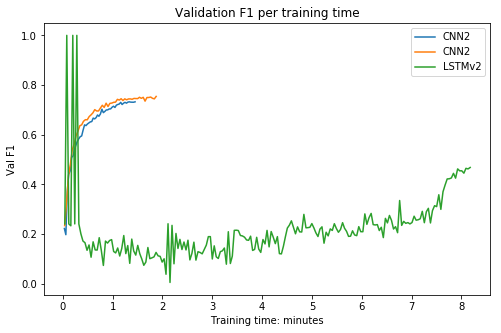

In [131]:
# F1 Per training time
#epochs = len(train_losses)
res = results
plt.figure(figsize=(8,5))

for i in range(len(res)):
    
    #epochs = len(res['Train_f1'][i])
    #plt.plot(np.arange(1,epochs+1), res['Train_f1'][i], label=res['Model'][i] +' train f1')
    plt.plot(res['Time'][i]/60, res['Val_f1'][i], label=res['Model'][i] +'')

plt.title('Validation F1 per training time')
plt.xlabel('Training time: minutes', fontsize=10)
plt.ylabel('Val F1', fontsize=10)
plt.legend()
plt.show()

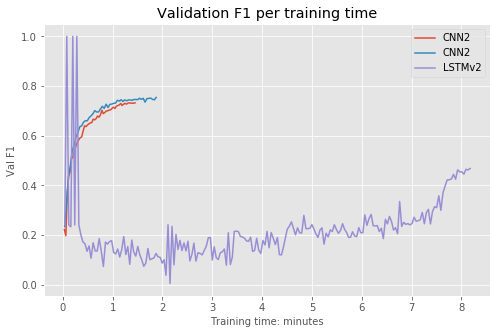

In [136]:
# SAME WITH DIFFERENT BACKGROUND

# grey background with lines
plt.style.use('ggplot')

#plt.switch_backend('agg')
# F1 Per training time
#epochs = len(train_losses)
res = results
plt.figure(figsize=(8,5))

for i in range(len(res)):
    
    #epochs = len(res['Train_f1'][i])
    #plt.plot(np.arange(1,epochs+1), res['Train_f1'][i], label=res['Model'][i] +' train f1')
    plt.plot(res['Time'][i]/60, res['Val_f1'][i], label=res['Model'][i] +'')

plt.title('Validation F1 per training time')
plt.xlabel('Training time: minutes', fontsize=10)
plt.ylabel('Val F1', fontsize=10)
plt.legend()
plt.show()

### Rest is Extra - not included yet

### Train individual

In [ ]:
# Ver2 - F1
N_EPOCHS = 50

for epoch in range(N_EPOCHS):
    #print(epoch)

    start = time.time()
    train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
    end = time.time(); elapsed = end-start
    
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
    times.append(elapsed) 
    train_losses.append(train_loss); train_f1s.append(train_f1)
    val_losses.append(valid_loss); val_f1s.append(valid_f1)
    
    #print(f'| Epoch:{epoch+1:02} | Train Loss: {train_loss:.3f} | Tr Precision: {train_precision:.3f} | Tr recall: {train_recall:.3f} | Tr f1: {train_f1:.3f} | Valid f1: {valid_f1:.3f} |')    
    print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

In [64]:
# on small1-data
# LSTM v2, 400 epoch, val f1 0.529 1900 sec
# CNN "CNN 200x3,5,7 channel" , 44 epochs. 0.756, about 140 sec

sum(times)

458.6244578361511

In [33]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)

### Results

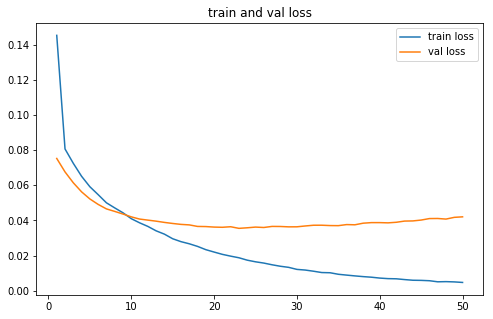

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = len(train_losses)

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), train_losses, label='train loss')
plt.plot(np.arange(1,epochs+1), val_losses, label='val loss')
plt.title('train and val loss')
plt.legend()

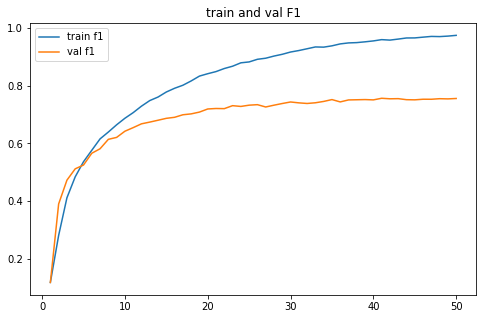

In [31]:
# Per ecpoh

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), train_f1s, label='train f1')
plt.plot(np.arange(1,epochs+1), val_f1s, label='val f1')
plt.title('train and val F1')
plt.legend()

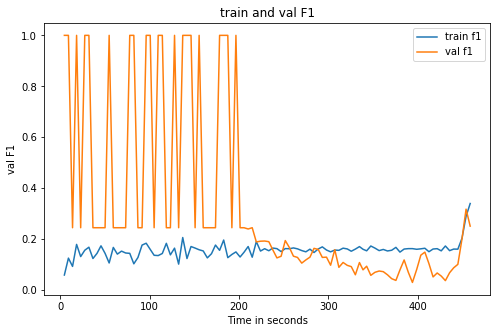

In [65]:
# Per time

times_cumul = pd.Series(times).cumsum() # cumulative time

plt.figure(figsize=(8,5))
plt.plot(times_cumul, train_f1s, label='train f1')
plt.plot(times_cumul, val_f1s, label='val f1')
plt.title('train and val F1')
plt.xlabel('Time in seconds', fontsize=10)
plt.ylabel('val F1', fontsize=10)
plt.legend()

In [50]:
### Save it
#results = pd.DataFrame()


In [118]:
model_name = type(model).__name__
model_name

'CNN2'

In [74]:
# Give description
desc = "LSTM v1"
test_f1 =0

In [76]:
test_f1 = 0.845
test_f1 = 0

In [59]:
res['Desc'][1]= 'LSTM fc2 hid_dim 200 1-layer'
res['Desc'][2]= 'LSTM fc2 hid_dim 200 2-layers'

/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
# Per time
#epochs = len(train_losses)

plt.figure(figsize=(8,5))

for i in range(len(res)):
    
    #epochs = len(res['Train_f1'][i])
    #plt.plot(np.arange(1,epochs+1), res['Train_f1'][i], label=res['Model'][i] +' train f1')
    plt.plot(res['Time'][i], res['Val_f1'][i], label=res['Desc'][i] +'')

plt.title('Validation F1')
plt.legend()
plt.show()

In [ ]:
epochs = len(train_losses)

plt.figure(figsize=(8,5))

for i in range(len(res)):
    
    epochs = len(res['Train_f1'][i])
    #plt.plot(np.arange(1,epochs+1), res['Train_f1'][i], label=res['Model'][i] +' train f1')
    plt.plot(np.arange(1,epochs+1), res['Val_f1'][i], label=res['Desc'][i] +'')

plt.title('Validation F1')
plt.legend()
plt.show()

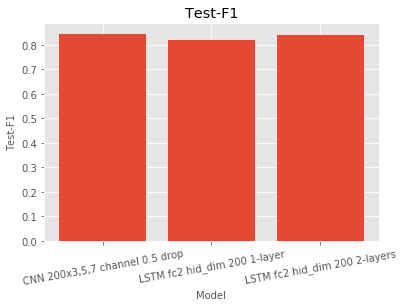

In [93]:
# Bar
index = np.arange(len(res))
values = res['Test_f1']
labels = res['Desc']

plt.ylim = ([0.5, 0.9]) # is set, but not effecting bar
plt.bar(index, values)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Test-F1', fontsize=10)
plt.xticks(index, labels, fontsize=10, rotation=10)
plt.title('Test-F1')

plt.show()

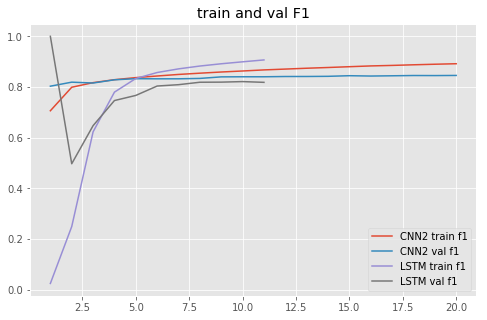

In [62]:
#epochs = len(train_losses)
plt.switch_backend('agg')
epochs = 40

plt.figure(figsize=(8,5))

epochs = len(res['Train_f1'][0])
plt.plot(np.arange(1,epochs+1), res['Train_f1'][0], label=res['Model'][0] +' train f1')
plt.plot(np.arange(1,epochs+1), res['Val_f1'][0], label=res['Model'][0] +' val f1')

epochs = len(res['Train_f1'][1])
plt.plot(np.arange(1,epochs+1), res['Train_f1'][1], label=res['Model'][1]+ ' train f1')
plt.plot(np.arange(1,epochs+1), res['Val_f1'][1], label=res['Model'][1] + ' val f1')


plt.title('train and val F1')
plt.legend()

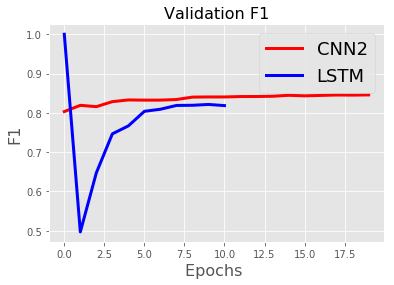

In [63]:
# grey background with lines
plt.style.use('ggplot')

fig1 = plt.figure()
plt.plot(res['Val_f1'][0],'r',linewidth=3.0)
plt.plot(res['Val_f1'][1],'b',linewidth=3.0)
plt.legend([res['Model'][0], res['Model'][1]],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1',fontsize=16)
plt.title('Validation F1',fontsize=16)
fig1.savefig('figure1.png')
plt.show()

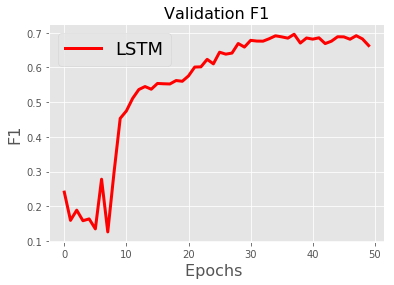

In [161]:
# grey background with lines
plt.style.use('ggplot')

fig1 = plt.figure()
plt.plot(res['Val_f1'][0],'r',linewidth=3.0)
#plt.plot(res['Val_f1'][1],'b',linewidth=3.0)
#plt.legend([res['Model'][0], res['Model'][1]],fontsize=18)
plt.legend([res['Model'][0]],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('F1',fontsize=16)
plt.title('Validation F1',fontsize=16)
fig1.savefig('figure.png')
plt.show()

### Save the model

For this version create the model object with same paramters as when training. Then load weights.
This version saves also gradients etc.

In [ ]:
torch.save(model.state_dict(), 'model.pkl')
#torch.save(model, 'filename.pt')

In [ ]:
model2 = RNN(input_dim=25002, embedding_dim=50, hidden_dim=256, output_dim=126)

In [ ]:
model2.load_state_dict(torch.load('model.pkl'))
                      

In [ ]:
model2.eval()

#### easier but not so compatible
This version does not save the gradients, only final model. 
Here you dont ened to create model object frist.

In [ ]:
#torch.save(model, 'models/model_cnn_200x3_4_5_drop05_emb5_f1_0845.pt')
torch.save(model, 'models/model_.pt')
# Works on CNN
# Some error on LSTM: TypeError: can't pickle torch.Device objects

In [ ]:
modelx = torch.load('modelx.pt')

### Test it on test data

In [136]:
test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} ||Prec:{test_precision:.3f} |Rec:{test_recall:.3f} |Test F1:{test_f1: .3f} |')

| Test Loss: 0.060 ||Prec:0.707 |Rec:0.650 |Test F1: 0.677 |


### Use final scoring 

The results will be ranked according to the highest micro-averaged F1 score. This will be calculated using the f1_score function found in scikit-learn, using a command like f1_score(y_true, y_pred, average='micro') where y_true is the matrix with the ground truth, and y_pred the predicted output. Both matrices are binary, a 1 in row i and column j means that the image/document i contains the label j.

In [ ]:
from sklearn.metrics import f1_score
f1_score()